### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from utilsforecast.preprocessing import fill_gaps
import lightgbm as lgb
import xgboost as xgb
from mlforecast import MLForecast
from utilsforecast.losses import mape
from sklearn.metrics import mean_absolute_percentage_error

### Load Data

In [2]:
df = pd.read_csv("../0-Data/train_0irEZ2H.csv")
df

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52
...,...,...,...,...,...,...,...,...,...
150145,212638,09/07/13,9984,223245,235.8375,235.8375,0,0,38
150146,212639,09/07/13,9984,223153,235.8375,235.8375,0,0,30
150147,212642,09/07/13,9984,245338,357.6750,483.7875,1,1,31
150148,212643,09/07/13,9984,547934,141.7875,191.6625,0,1,12


In [3]:
df["week"].unique()

array(['17/01/11', '24/01/11', '31/01/11', '07/02/11', '14/02/11',
       '21/02/11', '28/02/11', '07/03/11', '14/03/11', '21/03/11',
       '28/03/11', '04/04/11', '11/04/11', '18/04/11', '25/04/11',
       '02/05/11', '09/05/11', '16/05/11', '23/05/11', '30/05/11',
       '06/06/11', '13/06/11', '20/06/11', '27/06/11', '04/07/11',
       '11/07/11', '18/07/11', '25/07/11', '01/08/11', '08/08/11',
       '15/08/11', '22/08/11', '29/08/11', '05/09/11', '12/09/11',
       '19/09/11', '26/09/11', '03/10/11', '10/10/11', '17/10/11',
       '24/10/11', '31/10/11', '07/11/11', '14/11/11', '21/11/11',
       '28/11/11', '05/12/11', '12/12/11', '19/12/11', '26/12/11',
       '02/01/12', '09/01/12', '16/01/12', '23/01/12', '30/01/12',
       '06/02/12', '13/02/12', '20/02/12', '27/02/12', '06/03/12',
       '13/03/12', '20/03/12', '27/03/12', '03/04/12', '10/04/12',
       '17/04/12', '24/04/12', '01/05/12', '08/05/12', '15/05/12',
       '22/05/12', '29/05/12', '05/06/12', '12/06/12', '19/06/

In [4]:
df["week"] = pd.to_datetime(df["week"], format="%d/%m/%y")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   record_ID        150150 non-null  int64         
 1   week             150150 non-null  datetime64[ns]
 2   store_id         150150 non-null  int64         
 3   sku_id           150150 non-null  int64         
 4   total_price      150149 non-null  float64       
 5   base_price       150150 non-null  float64       
 6   is_featured_sku  150150 non-null  int64         
 7   is_display_sku   150150 non-null  int64         
 8   units_sold       150150 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 10.3 MB


In [5]:
# train_df["sales_week"] = train_df["week"]
# train_df = train_df.drop(columns=["week"])
# train_df

In [6]:
df

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52
...,...,...,...,...,...,...,...,...,...
150145,212638,2013-07-09,9984,223245,235.8375,235.8375,0,0,38
150146,212639,2013-07-09,9984,223153,235.8375,235.8375,0,0,30
150147,212642,2013-07-09,9984,245338,357.6750,483.7875,1,1,31
150148,212643,2013-07-09,9984,547934,141.7875,191.6625,0,1,12


### Data Aggregations

##### Units Sold

In [7]:
total_sales = df.groupby("week")["units_sold"].sum()
total_sales

week
2011-01-17     60029
2011-01-24     56752
2011-01-31     51467
2011-02-07     54656
2011-02-14    109207
               ...  
2013-06-11     56433
2013-06-18     53818
2013-06-25     68283
2013-07-02     61655
2013-07-09     68101
Name: units_sold, Length: 130, dtype: int64

In [8]:
total_sales_df = pd.DataFrame(
    {
        "unique_id": ["total"] * len(total_sales),
        "week": total_sales.index,
        "units_sold": total_sales.values
    }
)
total_sales_df

,unique_id,week,units_sold
0,total,2011-01-17,60029
1,total,2011-01-24,56752
2,total,2011-01-31,51467
3,total,2011-02-07,54656
4,total,2011-02-14,109207
...,...,...,...
125,total,2013-06-11,56433
126,total,2013-06-18,53818
127,total,2013-06-25,68283
128,total,2013-07-02,61655


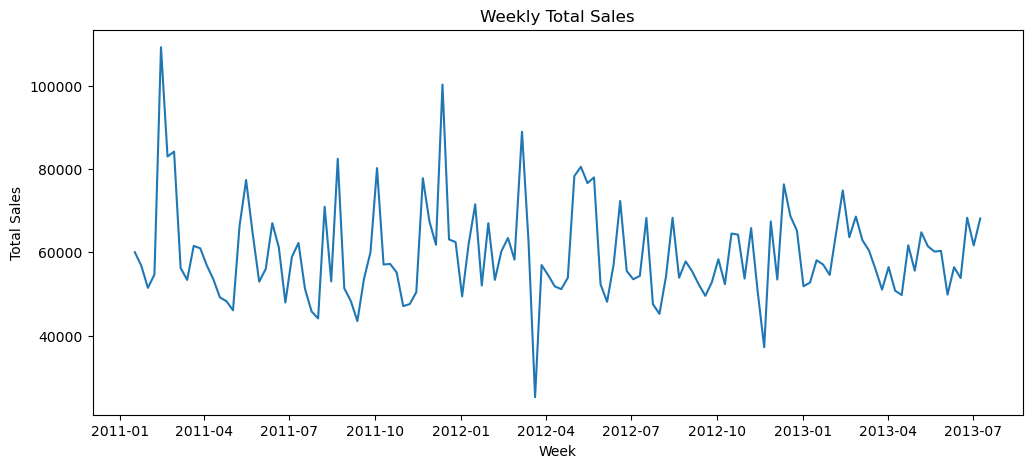

In [9]:
plt.figure(figsize=(12,5))
plt.plot(total_sales_df["week"], total_sales_df["units_sold"])
plt.xlabel("Week")
plt.ylabel("Total Sales")
plt.title("Weekly Total Sales")
plt.show()

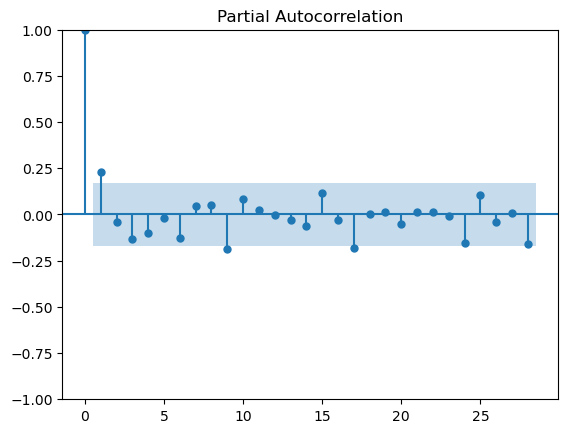

In [10]:
plot_pacf(total_sales, lags=28)
plt.show()

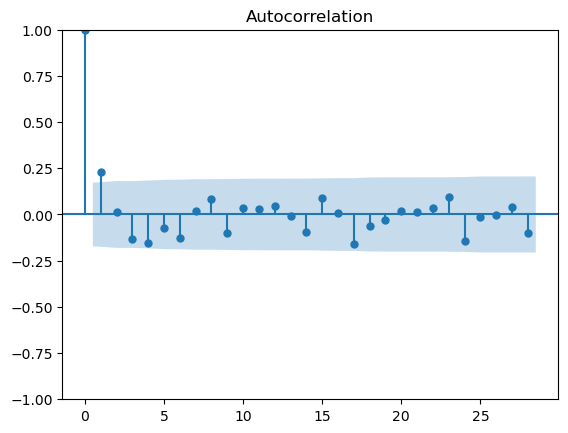

In [11]:
plot_acf(total_sales, lags=28)
plt.show()

##### Exogenous Features

In [12]:
def create_exogenous_features():    
    total_prices = []
    avg_base_prices = []
    counts_is_featured_sku = []
    counts_is_display_sku = []

    weeks = total_sales_df["week"].unique()
    for week in weeks:
        temp = df[df["week"] == week]
        total_prices.append(temp["total_price"].sum())
        avg_base_prices.append(temp["base_price"].mean())
        counts_is_featured_sku.append(temp["is_featured_sku"].sum())
        counts_is_display_sku.append(temp["is_display_sku"].sum())

    return total_prices, avg_base_prices, counts_is_featured_sku, counts_is_display_sku

total_sales_df["total_price"], total_sales_df["avg_base_price"], total_sales_df["count_is_featured_sku"], total_sales_df["count_is_display_sku"] = create_exogenous_features()
total_sales_df

,unique_id,week,units_sold,total_price,avg_base_price,count_is_featured_sku,count_is_display_sku
0,total,2011-01-17,60029,238189.4625,213.440942,219,189
1,total,2011-01-24,56752,237980.7000,214.789448,317,226
2,total,2011-01-31,51467,243927.9375,215.833214,12,111
3,total,2011-02-07,54656,244768.6875,215.801753,0,111
4,total,2011-02-14,109207,219204.1875,215.681461,122,241
...,...,...,...,...,...,...,...
125,total,2013-06-11,56433,244079.7000,224.946429,157,138
126,total,2013-06-18,53818,245855.2500,226.183279,125,146
127,total,2013-06-25,68283,241391.4375,225.558377,142,193
128,total,2013-07-02,61655,240601.9875,225.878539,216,239


In [13]:
def date_preprocessing(df:pd.DataFrame, date_col:str="week"):
    df["week_of_year"] = df[date_col].dt.isocalendar().week
    df["month"] = df[date_col].dt.month
    df["quarter"] = df[date_col].dt.quarter
    df["year"] = df[date_col].dt.year
    df["ds"] = [i+1 for i in range(len(df[date_col]))]

    return df.drop(columns=[date_col])

total_sales_df = date_preprocessing(total_sales_df)
total_sales_df

,unique_id,units_sold,total_price,avg_base_price,count_is_featured_sku,count_is_display_sku,week_of_year,month,quarter,year,ds
0,total,60029,238189.4625,213.440942,219,189,3,1,1,2011,1
1,total,56752,237980.7000,214.789448,317,226,4,1,1,2011,2
2,total,51467,243927.9375,215.833214,12,111,5,1,1,2011,3
3,total,54656,244768.6875,215.801753,0,111,6,2,1,2011,4
4,total,109207,219204.1875,215.681461,122,241,7,2,1,2011,5
...,...,...,...,...,...,...,...,...,...,...,...
125,total,56433,244079.7000,224.946429,157,138,24,6,2,2013,126
126,total,53818,245855.2500,226.183279,125,146,25,6,2,2013,127
127,total,68283,241391.4375,225.558377,142,193,26,6,2,2013,128
128,total,61655,240601.9875,225.878539,216,239,27,7,3,2013,129


In [14]:
total_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unique_id              130 non-null    object 
 1   units_sold             130 non-null    int64  
 2   total_price            130 non-null    float64
 3   avg_base_price         130 non-null    float64
 4   count_is_featured_sku  130 non-null    int64  
 5   count_is_display_sku   130 non-null    int64  
 6   week_of_year           130 non-null    UInt32 
 7   month                  130 non-null    int64  
 8   quarter                130 non-null    int64  
 9   year                   130 non-null    int64  
 10  ds                     130 non-null    int64  
dtypes: UInt32(1), float64(2), int64(7), object(1)
memory usage: 10.9+ KB


### Model Training

In [15]:
train_total_sales_df = total_sales_df.head(118)
train_total_sales_df

,unique_id,units_sold,total_price,avg_base_price,count_is_featured_sku,count_is_display_sku,week_of_year,month,quarter,year,ds
0,total,60029,238189.4625,213.440942,219,189,3,1,1,2011,1
1,total,56752,237980.7000,214.789448,317,226,4,1,1,2011,2
2,total,51467,243927.9375,215.833214,12,111,5,1,1,2011,3
3,total,54656,244768.6875,215.801753,0,111,6,2,1,2011,4
4,total,109207,219204.1875,215.681461,122,241,7,2,1,2011,5
...,...,...,...,...,...,...,...,...,...,...,...
113,total,55938,233858.8875,222.768214,265,222,12,3,1,2013,114
114,total,51045,234549.3000,222.892208,125,199,13,3,1,2013,115
115,total,56450,234547.1625,223.208052,301,219,14,4,2,2013,116
116,total,50782,247238.2125,223.853929,65,129,15,4,2,2013,117


In [16]:
test_total_sales_df = total_sales_df.tail(12)
test_total_sales_df

,unique_id,units_sold,total_price,avg_base_price,count_is_featured_sku,count_is_display_sku,week_of_year,month,quarter,year,ds
118,total,61677,253621.5000,225.313474,147,129,17,4,2,2013,119
119,total,55575,255414.1500,226.094448,147,138,18,4,2,2013,120
120,total,64793,238257.1500,227.078994,268,237,19,5,2,2013,121
121,total,61434,247394.9625,225.972922,29,112,20,5,2,2013,122
122,total,60173,238293.4875,225.546656,65,140,21,5,2,2013,123
123,total,60344,237223.3125,224.499188,128,179,22,5,2,2013,124
124,total,49840,245848.8375,224.580000,32,84,23,6,2,2013,125
125,total,56433,244079.7000,224.946429,157,138,24,6,2,2013,126
126,total,53818,245855.2500,226.183279,125,146,25,6,2,2013,127
127,total,68283,241391.4375,225.558377,142,193,26,6,2,2013,128


In [17]:
fcst = MLForecast(
    models=[
        lgb.LGBMRegressor(n_jobs=-1, random_state=0, objective="mape")
    ],
    freq=1,
    lags=[1],
)

prep_df = fcst.preprocess(
    df=train_total_sales_df,
    target_col="units_sold"
)
prep_df

,unique_id,units_sold,total_price,avg_base_price,count_is_featured_sku,count_is_display_sku,week_of_year,month,quarter,year,ds,lag1
1,total,56752.0,237980.7000,214.789448,317,226,4,1,1,2011,2,60029.0
2,total,51467.0,243927.9375,215.833214,12,111,5,1,1,2011,3,56752.0
3,total,54656.0,244768.6875,215.801753,0,111,6,2,1,2011,4,51467.0
4,total,109207.0,219204.1875,215.681461,122,241,7,2,1,2011,5,54656.0
5,total,82986.0,217753.5375,215.876396,40,229,8,2,1,2011,6,109207.0
...,...,...,...,...,...,...,...,...,...,...,...,...
113,total,55938.0,233858.8875,222.768214,265,222,12,3,1,2013,114,60453.0
114,total,51045.0,234549.3000,222.892208,125,199,13,3,1,2013,115,55938.0
115,total,56450.0,234547.1625,223.208052,301,219,14,4,2,2013,116,51045.0
116,total,50782.0,247238.2125,223.853929,65,129,15,4,2,2013,117,56450.0


In [18]:
cv_result = fcst.cross_validation(
    df=train_total_sales_df,
    target_col="units_sold",
    n_windows=4,
    h=12,
    static_features=[]
)
cv_result.head()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 69, number of used features: 9
[LightGBM] [Info] Start training from score 56003.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

,unique_id,ds,cutoff,units_sold,LGBMRegressor
0,total,71,70,77954,66600.721336
1,total,72,70,52305,51157.320493
2,total,73,70,48123,50924.996152
3,total,74,70,57112,52332.562628
4,total,75,70,72306,65419.738525


In [19]:
def evaluate_cv_results(df:pd.DataFrame):
    return mape(df, models=["LGBMRegressor"], id_col="cutoff", target_col="units_sold").set_index("cutoff")

cv_mape = evaluate_cv_results(cv_result)
cv_mape

,LGBMRegressor
cutoff,
70,0.084459
82,0.101609
94,0.129988
106,0.107968


In [20]:
cv_mape.mean()

LGBMRegressor    0.106006
dtype: float64

In [21]:
model = fcst.fit(
    df = train_total_sales_df,
    target_col="units_sold",
    fitted=True,
    static_features=[]
)
model

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 117, number of used features: 9
[LightGBM] [Info] Start training from score 55165.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

MLForecast(models=[LGBMRegressor], freq=1, lag_features=['lag1'], date_features=[], num_threads=1)

### Model Testing

In [22]:
X_test = test_total_sales_df[['unique_id', 'ds', 'total_price', 'avg_base_price', 'count_is_featured_sku', 'count_is_display_sku', 'week_of_year', 'month', 'quarter', 'year']]
preds = model.predict(
    h=12,
    X_df=X_test
)
preds.index = preds["unique_id"]
preds = preds.drop(columns=["unique_id"])
preds

,ds,LGBMRegressor
unique_id,,
total,119,54374.842311
total,120,56888.101504
total,121,63244.263312
total,122,48918.232278
total,123,54683.961126
total,124,63309.582736
total,125,48656.952285
total,126,57198.233794
total,127,53065.310478


In [23]:
# preds.to_csv("2-train-total-sales-preds.csv")

In [24]:
mean_absolute_percentage_error(y_true=test_total_sales_df["units_sold"], y_pred=preds["LGBMRegressor"])

0.06089389649316356

### Model Fitted Values

In [25]:
fitted_values = fcst.forecast_fitted_values()
fitted_values.index = fitted_values["unique_id"]
fitted_values["y"] = fitted_values["units_sold"]
fitted_values = fitted_values.drop(columns=["unique_id", "units_sold"])
fitted_values

,ds,LGBMRegressor,y
unique_id,,,
total,2,63685.050068,56752.0
total,3,51691.655814,51467.0
total,4,52892.200673,54656.0
total,5,62893.929075,109207.0
total,6,63054.185798,82986.0
...,...,...,...
total,114,58365.049939,55938.0
total,115,57247.300167,51045.0
total,116,59122.403641,56450.0


In [26]:
# fitted_values.to_csv("2-train-total-sales-fitted-values.csv")